## Clustering

This notebook is a movie recommendation model using K-means clustering and DBScan clustering models to recommend similar movies to the user. The two features extracted from the dataset are Average Movie Rating and tags of the movie given by various users.

In [1]:
import pandas as pd
import numpy as np
from functools import reduce

from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import DBSCAN

import matplotlib.pyplot as plt
import matplotlib.cm as cm

%matplotlib inline

### Reading the csv files

In [2]:
# Reading movies.csv
df_movies = pd.read_csv('../data/raw/movies.csv')
to_drop = ['genres']
df_movies.drop(to_drop, inplace=True, axis=1)
df_movies.head()

,movieId,title
0,1,Toy Story (1995)
1,2,Jumanji (1995)
2,3,Grumpier Old Men (1995)
3,4,Waiting to Exhale (1995)
4,5,Father of the Bride Part II (1995)


In [3]:
# Reading ratings.csv
df_ratings = pd.read_csv('../data/raw/ratings.csv')
df_ratings = df_ratings.groupby('movieId')['rating'].mean().reset_index(name='avg_rating')
df_ratings.head()

,movieId,avg_rating
0,1,3.920930
1,2,3.431818
2,3,3.259615
3,4,2.357143
4,5,3.071429


In [4]:
# Reading tags.csv
df_tags = pd.read_csv('../data/raw/tags.csv')
to_drop = ['userId','timestamp']
df_tags.drop(to_drop, inplace=True, axis=1)
df_tags.head()

,movieId,tag
0,60756,funny
1,60756,Highly quotable
2,60756,will ferrell
3,89774,Boxing story
4,89774,MMA


### Label Enocding on tags column

In [5]:
encoder = LabelEncoder()
df_tags['tagencode'] = encoder.fit_transform(df_tags['tag'].astype('str'))
df_tags.head()

,movieId,tag,tagencode
0,60756,funny,936
1,60756,Highly quotable,231
2,60756,will ferrell,1573
3,89774,Boxing story,73
4,89774,MMA,322


### Merging the dataframes on common column Movie Id

In [6]:
dfs = [df_movies, df_ratings, df_tags]
dfmerge = reduce(lambda left,right: pd.merge(left,right,on='movieId'), dfs)

In [7]:
dfmerge.head()

,movieId,title,avg_rating,tag,tagencode
0,1,Toy Story (1995),3.920930,pixar,1244
1,1,Toy Story (1995),3.920930,pixar,1244
2,1,Toy Story (1995),3.920930,fun,934
3,2,Jumanji (1995),3.431818,fantasy,901
4,2,Jumanji (1995),3.431818,magic board game,1117


In [8]:
#Choosing the features - tags and avg_rating
x = dfmerge.iloc[:,[2,4]].values

In [9]:
x

array([[   3.92093023, 1244.        ],
       [   3.92093023, 1244.        ],
       [   3.92093023,  934.        ],
       ...,
       [   3.5       ,  770.        ],
       [   3.5       ,  950.        ],
       [   3.5       , 1321.        ]])

### Elbow Method to determine number of clusters

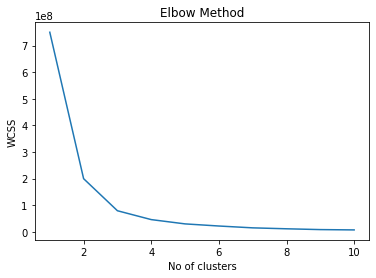

In [10]:
wcss =[]
for i in range (1,11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', max_iter =300, n_init = 10, random_state = 0)
    kmeans.fit(x)
    wcss.append(kmeans.inertia_)
plt.plot(range(1,11),wcss)
plt.title('Elbow Method')
plt.xlabel('No of clusters')
plt.ylabel('WCSS')
plt.show()



### Selecting the number of clusters with Silhouette analysis on KMeans clustering
Reference https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html

In [11]:
print(__doc__)
X = x
range_n_clusters = [2, 3, 4, 5, 6]

Automatically created module for IPython interactive environment


For n_clusters = 2 The average silhouette_score is : 0.6088953152198128
For n_clusters = 3 The average silhouette_score is : 0.6144199749230699
For n_clusters = 4 The average silhouette_score is : 0.582882052870002
For n_clusters = 5 The average silhouette_score is : 0.5739752114840838
For n_clusters = 6 The average silhouette_score is : 0.5718413556832314


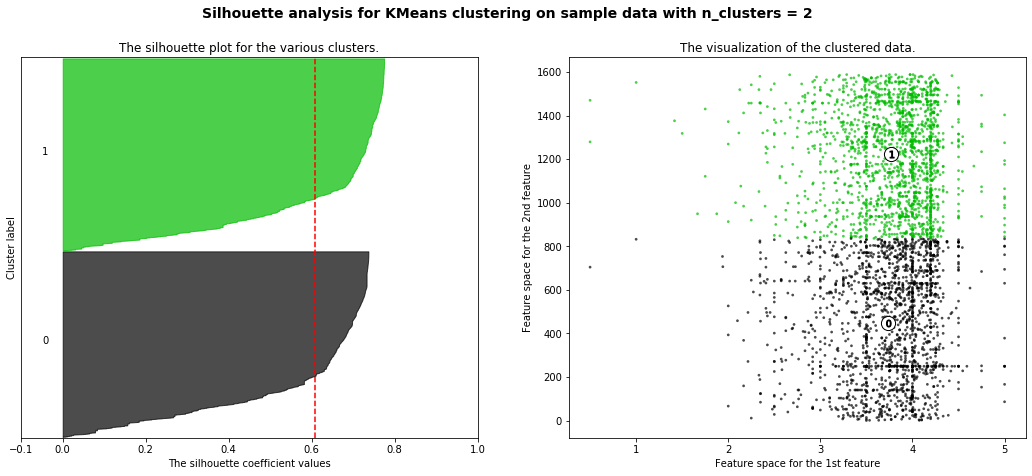

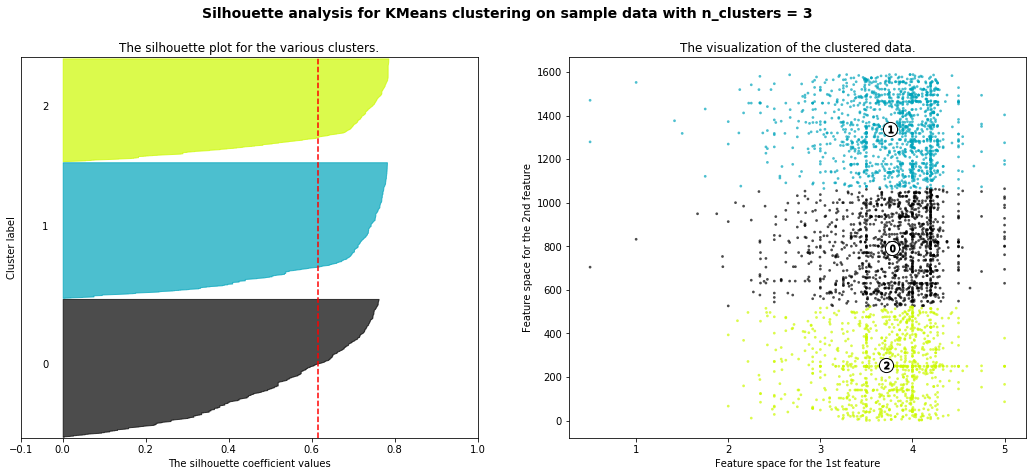

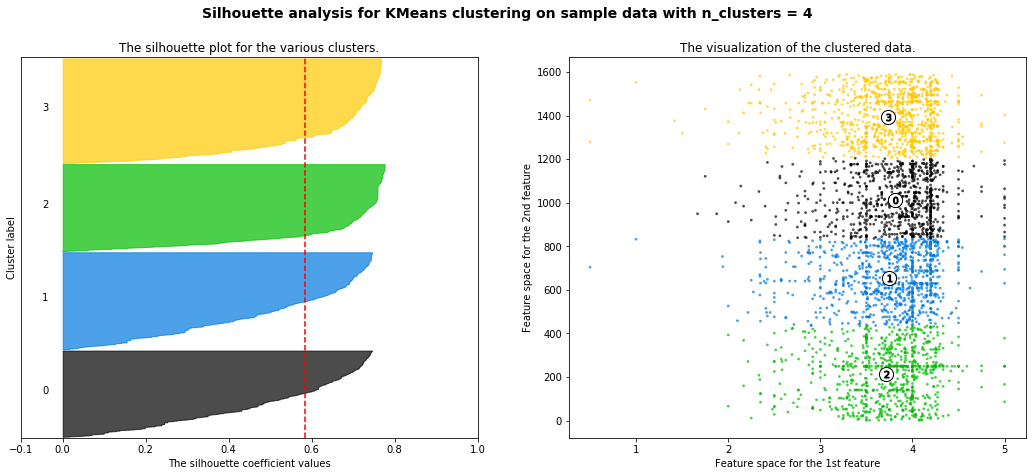

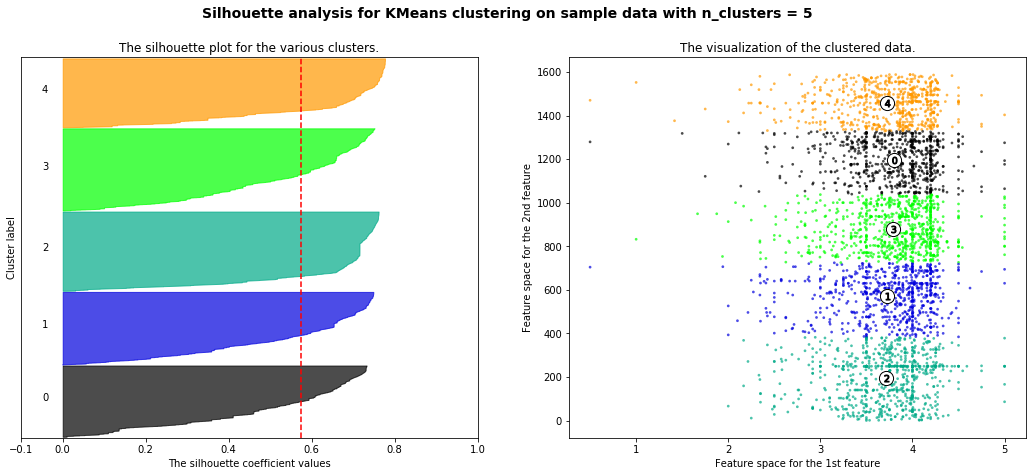

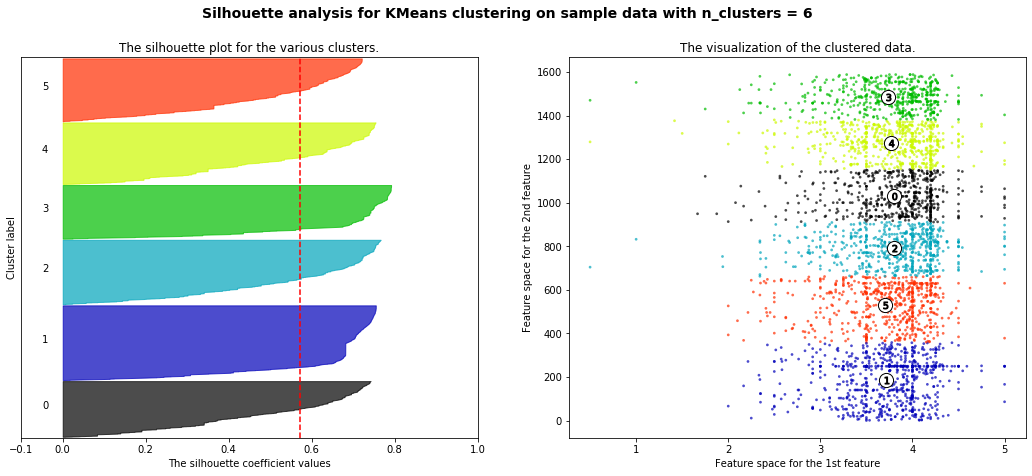

In [12]:
for n_clusters in range_n_clusters:
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

### Highest Average Silhouette score is 0.614 for number of clusters "3"

### From both the Elbow method and Silhouette analysis we can take number of clusters as "3" 

## ** K-Means Clustering model **

In [13]:
#we will take the cluster value as 3
kmeans=KMeans(n_clusters= 3)
y_Kmeans = kmeans.fit_predict(x)

In [14]:
y_Kmeans

array([1, 1, 2, ..., 2, 2, 1], dtype=int32)

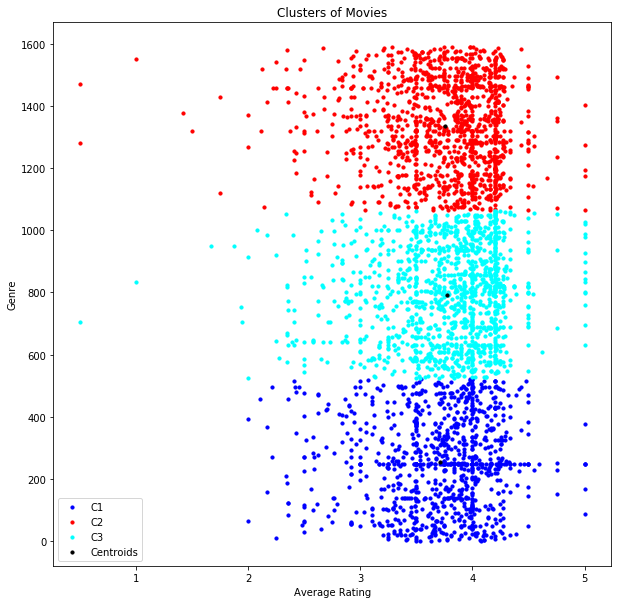

In [15]:
# Detailed Visualising the clusters

plt.figure(figsize=(10,10))
plt.scatter(x[y_Kmeans == 0, 0], x[y_Kmeans == 0,1],s = 10, c='blue', label = 'C1')

plt.scatter(x[y_Kmeans == 1, 0], x[y_Kmeans == 1,1],s = 10, c='red', label = 'C2')

plt.scatter(x[y_Kmeans == 2, 0], x[y_Kmeans == 2,1],s = 10, c='cyan', label = 'C3')

plt.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], s = 10, c = 'black', label = 'Centroids')
   
plt.title('Clusters of Movies')
plt.xlabel('Average Rating')
plt.ylabel('Genre')
plt.legend()
plt.show()

In [16]:
print(kmeans.cluster_centers_)

[[   3.70735957  254.543     ]
 [   3.75510817 1335.66439909]
 [   3.77668855  791.86631815]]


#### Finding the Movie Id's in all the clusters

In [17]:
row_dict = []
for index,row in dfmerge.iterrows():
    row_dict.append(row['movieId'])
clusternames = kmeans.predict(x)
print(np.unique(clusternames))

[0 1 2]


In [18]:
clusters = {}
n =0
for moviename in clusternames:
    if moviename in clusters:
        if(row_dict[n] not in clusters[moviename]):
            clusters[moviename].append(row_dict[n])
    else:
        clusters[moviename] = [row_dict[n]]
    n = n+1

In [19]:
for item in clusters:
    print ("cluster" , item +1)
    n=1
    for i in clusters[item]:
        print(i)
        n=n+1
        if (n>5):
            print('\n')
            break

cluster 2
1
2
3
5
7


cluster 3
1
2
25
31
36


cluster 1
2
16
17
21
26




## ** DBSCAN Clustering model **

In [20]:
min_samples = dfmerge.shape[1]+1 #  Rule of thumb; number of dimensions D in the data set, as minPts ≥ D + 1
dbscan = DBSCAN(eps=3, min_samples=min_samples).fit(x)

### Visualizing both DBScan and K-means models

Text(0.5, 1.0, 'DBSCAN')

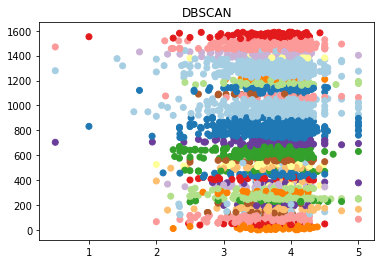

In [21]:
y_pred = dbscan.fit_predict(x)
plt.scatter(x[:,0], x[:,1],c=y_pred, cmap='Paired')
plt.title("DBSCAN")

Text(0.5, 1.0, 'K-means')

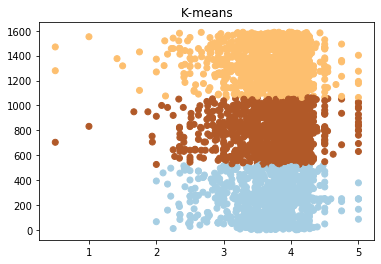

In [22]:
y_pred = kmeans.predict(x)
plt.scatter(x[:,0], x[:,1],c=y_pred, cmap='Paired')
plt.title("K-means")